Last Updated: December 20, 2022
In this notebook, we run `scipy.optimize.minimize` to estimate $\sigma_8$ based on different covariance matrices of simulations and their mean values. The goal is to see how the bias of the mean values and the increased covariances affect parameter estimation. We first set up a toy example where we set all of the cosmology to be the same and only sample over $\sigma_8$. 

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32" #need to be set early

In [2]:
#auto load changes 
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [3]:
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/SkyLens/skylens') #path to skylens
sys.path.insert(0,'/global/homes/t/tanveerk/lselgsXplanck/src/') #path to helper functions

import skylens
import utilsCross #helper functions

skylens main: /global/homes/t/tanveerk/SkyLens/skylens/__init__.py


In [4]:
#import multiprocessing
from distributed import LocalCluster
from dask.distributed import Client
from dask.distributed import Lock

Import data

In [6]:
pcls_binned = pickle.load(open( "/pscratch/sd/t/tanveerk/img-sys/stats/nnp/cov.p", "rb" ) )

Calculate covariances

In [7]:
covs = {} # save covariance matrices
corrs = {} #save correlation matrices
exps = np.array(['A', 'B', 'C']) #experiment names
tracers = np.array(['cgg', 'ckg'])

In [8]:
for exp in exps:
    covs[exp] = {}
    corrs[exp] = {}
    
    for tracer in tracers:
        covs[exp][tracer] = np.cov(pcls_binned[exp][tracer].T)
        corrs[exp][tracer] = np.corrcoef(pcls_binned[exp][tracer].T)

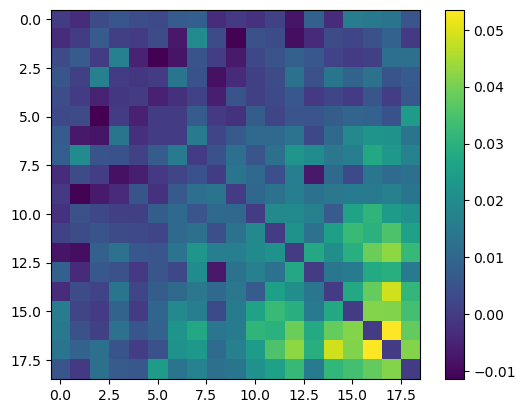

In [9]:
plt.imshow(corrs['C']['cgg'] - corrs['A']['cgg'])
plt.colorbar()

## Set up theory code

In [10]:
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,
               memory_spill_fraction=.99,memory_monitor_interval='2000ms')
client=Client(c)
print(client)

<Client: 'inproc://128.55.73.88/125067/1' processes=1 threads=4, memory=150.00 GB>


#### Skylens setup

Setup cosmology. For testing, we set everything to Planck18 except $A_s$. 

In [11]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo_planck

cosmo_fid=dict({'h':cosmo_planck.h,
                'Omb':cosmo_planck.Ob0,
                'Omd':cosmo_planck.Om0-cosmo_planck.Ob0,
                #'s8':0.817,
                'Om':cosmo_planck.Om0,
                #'Ase9':2.2,
                'mnu':0,
                'Omk':cosmo_planck.Ok0,
                'tau':0.06,
                'ns':0.965,
                'OmR':cosmo_planck.Ogamma0+cosmo_planck.Onu0,
                'w':-1,
                'wa':0,
                'T_cmb':cosmo_planck.Tcmb0, 
                'Neff':cosmo_planck.Neff,
                'z_max':1090,
                'use_astropy':True})

In [12]:
pk_params={'non_linear':1,
           'kmax':10,
           'kmin':3.e-4,
           'nk':500,
           'scenario':'dmo', 
           'halofit_version':'takahashi',
           'pk_func' :'camb_pk'}

In [13]:
cosmo_params = cosmo_fid

setup wigner file

In [14]:
wigner_files={} 
wigner_files[0]= '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'
#wigner_files[0] = '/global/cscratch1/sd/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'

Setup Skylens variables

In [15]:
test = True
if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE - 1
    binsize = 10
else:
    NSIDE = 1024
    #lmax_cl = 3 * NSIDE - 1
    lmax_cl = 3 * NSIDE - 1
    binsize = 50

In [16]:
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=50
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0

do_cov=False # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
#window_lmax= 3*NSIDE - 1 #smaller value for testing. This should be 2X ell_max in the measurements.
window_lmax = 2*NSIDE

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [17]:
def SkyLens_cls(nside, l, cosmo_params, pk_params,
                dndz_dict, gal_window_dict, gal_maskfile,
                cmb_SN_file, cmb_window_map_arr,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = None, mag_fact = 0, 
                zmin_gal = 0.0, zmax_gal = 1.6, nz = 140, 
                use_window = False,
                Win = None):
    """Returns Skylens object for C_ell calculation based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        l (array) : multipoles to evaluate 
        dndz_dict (dict) : dictionary containing dndz file location per tomographic bin
        gal_window_dict (dict) : dictionary containing galaxy window function file 
                                location per tomographic bin
        gal_maskfile (str) : Galaxy mask file location
        cmb_SN_file (str) : CMB noise curve file location 
        cmb_window_map_arr (str) : CMB window function file location
        z_cmb (float) : redshift of CMB 
        zmax_cmb (float) : maximum redshift where CMB lensing kernel should be integrated up to
        bg1 (float) : linear bias term for galaxies
        bz1 (dict) : redshift dependent galaxy bias
        mag_fact (float) : magnification bias 
        zmin_gal (float) : min redshift for galaxy sample
        zmax_gal (float) : max redshift for galaxy sample
        nz (int) : number of redshifts where P(k) will be evaluated
        use_window (bool) : whether to evaluate window function
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        kappa0 (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
            
    #tomographed redshift bins for the galaxies
    zl_bin = utilsCross.DESI_elg_bins(l=l, nside = nside, ntomo_bins = len(gal_window_dict), 
                                 bg1 = bg1, bz1 = bz1, mag_fact = mag_fact, 
                                 dndz_arr = dndz_dict, 
                                 gal_maskfile = gal_maskfile, gal_window_arr = gal_window_dict,
                                use_window = use_window)

    np.array([cmb_window_map_file])
    #redshift bins for cmb
    zs_bin = utilsCross.cmb_bins_here(zs = z_cmb, l=l, nside = nside, 
                                 zmax_cmb = zmax_cmb, SN_file = cmb_SN_file, 
                                 cmb_window_map_arr = cmb_window_map_arr,
                                use_window = use_window) # lensing source bin
    
    #names of maps
    #corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    #corrs=[corr_kk, corr_gg, corr_gk]
    corrs = [corr_gg, corr_gk]
    
    #tmpz1 = np.linspace(max(zmin_gal, 1e-4), zmax_gal, nz)
    tmpz1 = np.linspace(0.01, zmax_gal + 0.5, nz)
    #tmpz2 = np.logspace(-4, np.log10(zmax_cmb), nz) #
    #z_PS = np.sort(np.unique(np.around(np.append(tmpz1, tmpz2), 
    #                                   decimals = 3))) #redshifts where P(k) will be evaluated
    z_PS = tmpz1
    print("z_PS: ", len(z_PS))
    
    if Win is not None:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, 
                                 galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
        
    else:
        kappa0 = skylens.Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS, pk_params = pk_params)
    
    return kappa0

In [18]:
wtype = 'nnp' #window type 
cmb_SN_file = '/pscratch/sd/t/tanveerk/cmb/lensing/MV/nlkk.dat'
#cmb_SN_file = '/global/cscratch1/sd/tanveerk/cmb/lensing/MV/nlkk.dat'
gal_maskfile = '/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_bool_dr9.npy'
cmb_window_map_file = np.array(['/global/homes/t/tanveerk/lselgsXplanck/finalproducts/mask_rotated_eq_nside_1024.npy'])
gal_window_map_file = "/global/homes/t/tanveerk/lselgsXplanck/finalproducts/Wg_map_nnp.npy"
gal_window_dict = np.array([gal_window_map_file])

#dndz file
redz_file = pd.read_csv("/global/homes/t/tanveerk/lselgsXplanck/finalproducts/fuji_pz_single_tomo.csv")
dndz = {}
dndz['zrange'] = np.array(redz_file['Redshift_mid'])
dndz['dndz'] = np.array(redz_file['pz'])
zrange = dndz['zrange']

Define galaxy linear bias and magnification bias

In [19]:
cosmo_params2 = deepcopy(cosmo_params)
cosmo_params2['Ase9'] = 2.2

In [20]:
cosmo_params

{'h': 0.6766,
 'Omb': 0.04897,
 'Omd': 0.26069,
 'Om': 0.30966,
 'mnu': 0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'OmR': 0.0014936944554559174,
 'w': -1,
 'wa': 0,
 'T_cmb': <Quantity 2.7255 K>,
 'Neff': 3.046,
 'z_max': 1090,
 'use_astropy': True}

In [21]:
#define cosmology object
tmpcosmo = skylens.cosmology(cosmo_params=cosmo_params2)

bg1 = None
bz1 = {}
bz1[0] = 1./tmpcosmo.DZ_int(z=zrange)

mag_fact = 2.621 # set magnification bias ##FIXME: need to change it based on Rongpu's method

In [22]:
kappa0 = SkyLens_cls(nside = NSIDE, l = l, cosmo_params=cosmo_params2, pk_params=pk_params,
                dndz_dict = dndz, gal_window_dict = gal_window_dict, gal_maskfile = gal_maskfile,
                cmb_SN_file = cmb_SN_file, cmb_window_map_arr = cmb_window_map_file,
                z_cmb = 1090, zmax_cmb = 1090,
                bg1 = None, bz1 = bz1, mag_fact = mag_fact, 
                zmin_gal = 0.0, zmax_gal = 3, nz = 140, 
                use_window = use_window,
                Win = None)

0.0 3.000000000000001 None 0.0029767682558078574
cmb yes
processing cmb lensing window
z_PS:  140


/global/homes/t/tanveerk/lselgsXplanck/src/utilsCross.py:55: RuntimeWarning: invalid value encountered in sqrt
  window_map_noise = np.sqrt(window_map)
/global/homes/t/tanveerk/SkyLens/skylens/tracer_utils.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_max_all=np.array([self.z_bins[tracer]['zmax'] for tracer in self.tracers])


Tracer utils has tracers:  ['galaxy', 'kappa']


/global/homes/t/tanveerk/SkyLens/skylens/angular_power_spectra.py:27: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


power spectra camb_pk
True
Win gen: step size 265 767 513.0 1
wigner_files: {0: '/pscratch/sd/t/tanveerk/wig3j_l3072_w6144_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 3.790855407714844e-05
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 0.0016946792602539062 302.079 0.0
cl+cov bags done 2 0 0.07988691329956055
set_window_cl done 1.5964102745056152
setting windows, coupling matrices  <Client: 'inproc://128.55.73.88/125067/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.00045037269592285156 604.069 inproc://128.55.73.88/125067/3
done lm 0 0.15574336051940918
doing lm 265
done lm cl+cov graph 265 0.0006504058837890625 604.069 inproc://128.55.73.88/125067/3
done lm 265 0.15528035163879395
doing lm 530
done lm cl+cov graph 530 0.0008387565612792969 604.069 inproc://128.55.73.88/125067/3
coupling_matrix_large (265, 767)
coupling_matri

In [23]:
Win=kappa0.Win

In [24]:
Win['cl'][('galaxy', 'kappa')][(0, 0)]['M']

array([[ 2.32842909e-01, -2.56175723e-04,  1.50044779e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.68527169e-04,  2.62851857e-01,  4.71207297e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.50223895e-02,  7.85345496e-05,  2.59660392e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.54762540e-01, -1.32419849e-04,  3.15731770e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.32593060e-04,  2.54762534e-01, -1.32419971e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.16557752e-02, -1.32592955e-04,  2.54762541e-01]])

In [25]:
cl0G=kappa0.cl_tomo()

scatter_dict got empty dictionary
[('galaxy', 'galaxy'), ('galaxy', 'kappa')]
cl graph done
gather_dict got empty dictionary


In [26]:
corr_kk = ('kappa', 'kappa')
corr_gg = ('galaxy', 'galaxy')
corr_kg = ('kappa', 'galaxy')
bi = (0,0)

In [27]:
cl0G['cl_b'][corr_gg][bi].compute()

array([2.78970743e-06, 2.52290273e-06, 2.25703445e-06, 2.01862361e-06,
       1.81847243e-06, 1.65771769e-06, 1.53063911e-06, 1.42865541e-06,
       1.34263095e-06, 1.26506651e-06, 1.19068593e-06, 1.11695756e-06,
       1.04364459e-06, 9.71863051e-07, 9.03384412e-07, 8.39917998e-07,
       7.82667104e-07, 7.32118806e-07, 6.88091258e-07, 6.49833190e-07,
       6.16298403e-07, 5.86377445e-07, 5.59067762e-07, 5.33602728e-07,
       5.09489983e-07, 4.86458335e-07, 4.64482464e-07, 4.43599895e-07,
       4.23904124e-07, 4.05487349e-07, 3.88338573e-07, 3.72457047e-07,
       3.57720795e-07, 3.44000725e-07, 3.31163877e-07, 3.19072209e-07,
       3.07619140e-07, 2.96732936e-07, 2.86370611e-07, 2.76511479e-07,
       2.67150658e-07, 2.58289555e-07, 2.49925159e-07, 2.42045547e-07,
       2.34627013e-07, 2.27635415e-07, 2.21030052e-07, 2.14765654e-07,
       2.08799506e-07, 2.03093056e-07, 1.97614727e-07, 1.92343911e-07,
       1.87268480e-07, 1.82381382e-07, 1.77677433e-07, 1.73159794e-07,
      

In [28]:
cl0G['pseudo_cl_b'][corr_gg][bi].compute()

array([9.01034468e-07, 8.17750624e-07, 7.34331613e-07, 6.59063230e-07,
       5.95451102e-07, 5.43958575e-07, 5.02916931e-07, 4.69724897e-07,
       4.41591962e-07, 4.16200610e-07, 3.91917420e-07, 3.67942383e-07,
       3.44179209e-07, 3.20957531e-07, 2.98811877e-07, 2.78264509e-07,
       2.59682021e-07, 2.43219633e-07, 2.28821153e-07, 2.16256454e-07,
       2.05202331e-07, 1.95313274e-07, 1.86277444e-07, 1.77853641e-07,
       1.69883797e-07, 1.62282460e-07, 1.55033650e-07, 1.48146808e-07,
       1.41648150e-07, 1.35560888e-07, 1.29885800e-07, 1.24616310e-07,
       1.19719121e-07, 1.15151845e-07, 1.10870328e-07, 1.06831630e-07,
       1.03001980e-07, 9.93591827e-08, 9.58890546e-08, 9.25845826e-08,
       8.94437860e-08, 8.64665242e-08, 8.36514170e-08, 8.09946191e-08,
       7.84888897e-08, 7.61237788e-08, 7.38865202e-08, 7.17619403e-08,
       6.97360156e-08, 6.77970877e-08, 6.59356178e-08, 6.41450102e-08,
       6.24210844e-08, 6.07611470e-08, 5.91635575e-08, 5.76284943e-08,
      

## Mock data

In [56]:
def f(x):
    return -5*x**2 + 3

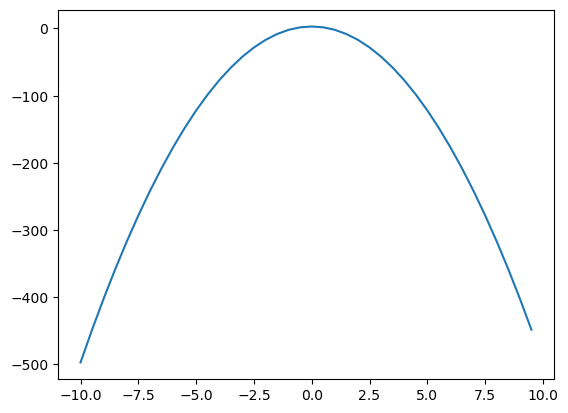

In [57]:
tmpx = np.arange(-10,10, 0.5)
plt.plot(tmpx, f(tmpx))

In [59]:
nf = lambda x : -1 * f(x)
minimize(fun = nf, x0 = -1.2)

      fun: -2.9999999999999996
 hess_inv: array([[0.1]])
      jac: array([-2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-8.79316039e-09])

## Set up likelihood

In [ ]:
from scipy.optimize import minimize

In [ ]:
model = 

In [51]:
data = pcls_binned['A']['cgg']

In [ ]:
loss = model - data
chisq = loss @ covinv @ loss

In [63]:
def loglike(params, x, y):
    a = params[0]
    b = params[1]
    
    loss = np.sum((y - (-a * x**2 + b))**2)
    
    return loss

## Set up optmizer

In [ ]:
minimize(fun = loglike, x0 = np.array([-4.5, 2.5]), args=(tmpx, f(tmpx)))

      fun: 1.0350667841835082e-11
 hess_inv: array([[1.39752046e-05, 4.66422797e-04],
       [4.66422797e-04, 2.80668609e-02]])
      jac: array([ 8.35700398e-11, -1.26298971e-12])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([4.99999998, 2.99999942])